# SVM from scratch with plain Python with detailed comments


## Support Vector Machines for classification

In [1]:
# importing libraries
import sys
import pickle

import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
%matplotlib inline

## PART 1

## Data Preprocessing 

### To-do steps
1. Remove rows with `NaN` values from `df_train` and `df_test`.
2. Create `X_train` and `X_test` by selecting columns `X1` through `X36`. Create `y_train` and `y_test` by selecting column `Class`.
2. Normalize `X_train` using `MinMaxScaler` from scikit-learn. Then normalize `X_test` on the normalization parameters derived from `X_train`.

In [4]:
# Step 1: Drop NaN values

train_df = train_df.dropna()
test_df = test_df.dropna()

# Step 2: Create train and test data

X_train = train_df.loc[:, train_df.columns!='Class']
X_test = test_df.loc[:, test_df.columns!='Class']

y_train = train_df["Class"].to_numpy()
y_test = test_df["Class"].to_numpy()

# Step 3: Normalize data

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# fit_transform() is used on the training data so that we can scale the training data 
    # and also learn the scaling parameters of that data. 
# Using the transform method we can use the same mean 
    # and variance as it is calculated from our training data to transform our test data

In [5]:
# Convert to binary classification
y_train[y_train != 6] = 0
y_train[y_train == 6] = 1

y_test[y_test != 6] = 0
y_test[y_test == 6] = 1

## PART 2 

## Hyperparameter Tuning 

Consider the binary classification that consists of distinguishing class 6 from the rest of the data points. Use SVMs combined with polynomial kernels to solve this classification problem. For each value of the polynomial degree, $d$ = 1, 2, 3, 4, plot the average 5-fold cross-validation error plus or minus one standard deviation as a function of $C$ (let the other parameters of the polynomial kernels be equal to their default values) on the training data.

**Choose a minimum of 5 $C$ values spread across a wide range**

**Report the best value of the trade-off constant $C$ measured on the training internal cross-validation.**

In [6]:
def cross_validation_score(X, y, c_vals, n_folds, d_vals):
    """
    Calculates the cross validation error and returns its mean and standard deviation.
    
    Args:
        X: features
        y: labels
        c_vals: list of C values
        n_folds: number of cross-validation folds
        d_vals: list of degrees of the polynomial kernel
    
    Returns:
        Tuple of (list of error_mean, list of error_std)       
    """
    
    error_mean = np.zeros((len(c_vals),len(d_vals)))
    error_std = np.zeros((len(c_vals),len(d_vals)))
    
   
    
    # data split into train and test using StratifiedKFold
    data_fold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=1)
    
    for i in range(len(c_vals)):

        for j in range(len(d_vals)):

            

            error_temp=[]

            for train_index, test_index in data_fold.split(X, y):

                x_train_fold, x_test_fold = X[train_index], X[test_index]
                y_train_fold, y_test_fold = y[train_index], y[test_index]

                SVM_Model = SVC(kernel='poly', C=c_vals[i], degree=d_vals[j])
                SVM_Model.fit(x_train_fold, y_train_fold)
                pred = SVM_Model.predict(x_test_fold)

                error_temp.append( mean_absolute_error(pred,y_test_fold) )
                #mean_absolute_error(pred, y_test_fold)
            error_mean[i][j]=np.mean(error_temp)
            error_std[i][j]=np.std(error_temp)

            
    return error_mean, error_std

In [7]:

n_folds = 5
d_vals= [1, 2, 3, 4]
c_vals = [0.01, 0.1, 0.5, 1, 2, 3, 4, 5, 10, 100] # Provide a list of C values

In [8]:
error_mean, error_std = cross_validation_score(X_train, y_train, c_vals, n_folds, d_vals)

**Plot the average cross validation error.**

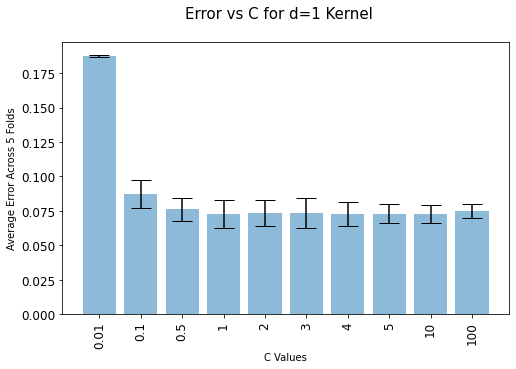

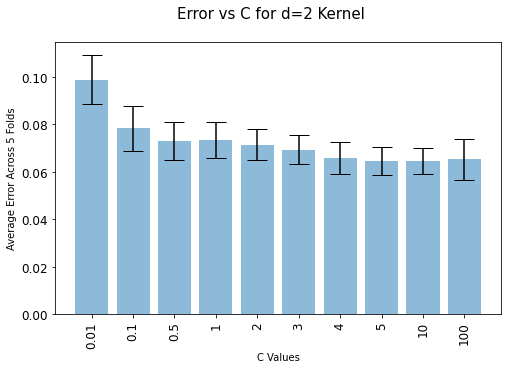

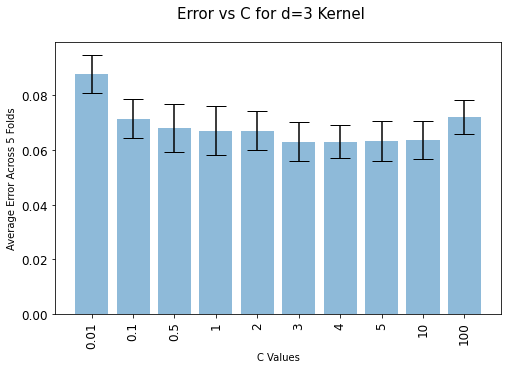

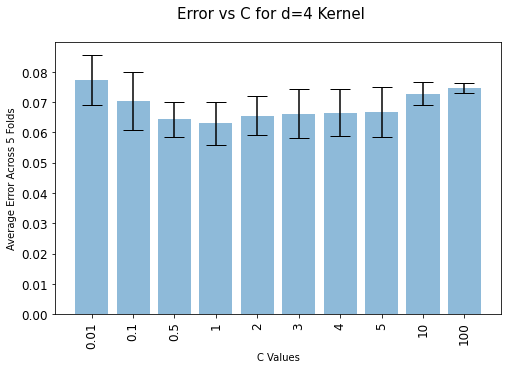

In [9]:
for i,d_val in enumerate(d_vals):
    plt.rcParams.update({'font.size': 12})
    plt.figure(figsize = (8,5)) 
    plt.bar(range(len(c_vals)), error_mean[:,i], 
            yerr=error_std[:,i],
            align='center',
            alpha=0.5,
            ecolor='k',
            capsize=10,
            label = "Average Error")
    plt.suptitle('Error vs C for d={} Kernel'.format(d_val), fontsize=15)
    plt.xlabel('C Values', fontsize=10)
    plt.xticks(range(len(c_vals)), c_vals, rotation='vertical')
    plt.ylabel('Average Error Across {} Folds'.format(n_folds), fontsize=10)

**Plot $(C; d)$ pairs with their corresponding cross validation errors.**

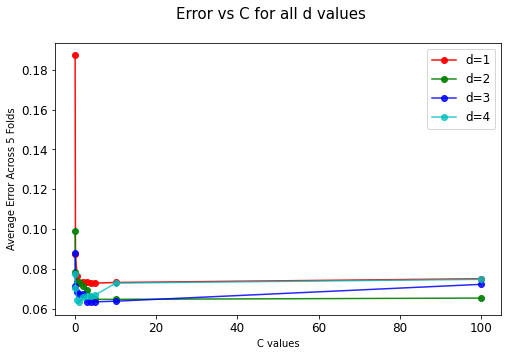

In [10]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize = (8,5))
colors = ['r', 'g', 'b', 'c', 'y']
for i,d_val in enumerate(d_vals):
    plt.plot(c_vals, error_mean[:,i],
             marker='o', 
             color=colors[i%5], 
             alpha=1 - 0.2 * d_val/len(d_vals), 
             label = "d={}".format(d_val))
plt.suptitle('Error vs C for all d values', fontsize=15)
plt.xlabel('C values', fontsize=10)
plt.ylabel('Average Error Across {} Folds'.format(n_folds), fontsize=10)
plt.legend()

## PART 3 

## Model Training and Testing

**Build models on the full training data on the best $C$ value you found previously for each $d$ value using the 5-fold cross validation.**

Return test error, number of support vectors, number of margin violations, and margin size

A data point (i.e., x) is said to violate margin if **distance of data point 
from hyperplane < margin size**. Therefore, number of total margin violations is count of such data points present in dataset.


Hint: Margin Size: Use the dual coefficients (alpha values) of SVM along with support vectors to calculcate margin. Please refer to slide 17 in slide deck 13 for more details.

In [11]:
def build_model(X_train, y_train, X_test, y_test, c_vals, d_vals):
    """
    Trains model on a dataset for given values of C and d. Returns the error on the test data,
    the number of support vectors, the number of margin violations, and the margin size.
    
    Args:
        X_train: features in training data
        y_train: train labels
        X_test: features in test data
        y_test: test labels
        c_vals: list of C values
        d_vals: list of degrees of the polynomial kernel
    
    Returns:
        Tuple of (error_test, support_vectors, margin_violations, margin_size)       
    """
    error_test = np.zeros(len(d_vals))
    support_vectors = np.zeros(len(d_vals))
    margin_violations = np.zeros(len(d_vals))
    margin_size = np.zeros(len(d_vals))
    

    
    # data split into train and test using StratifiedKFold (5-fold)
    data_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    

    for j in range(len(d_vals)):

        error_temp=[]


        SVM_Model = SVC(kernel='poly', C=c_vals[j], degree=d_vals[j])
        SVM_Model.fit(X_train, y_train)
        pred = SVM_Model.predict(X_test)

        error_temp.append( sum(pred!=y_test)/len(y_test) )

        # calculate the margin size
        margin_siz_tempo = 1/np.sqrt(np.sum(SVM_Model.dual_coef_**2))

        # calculate the number of margin violations
        y_tempo = SVM_Model.decision_function(X_test)
        w_norm = np.linalg.norm(SVM_Model.dual_coef_)
        dist = y_tempo / w_norm
            
        count = 0
        for point in dist:
            if abs(point) <= margin_siz_tempo:
                count += 1
                    
        
        error_test[j]=np.mean(error_temp)
        support_vectors[j]=len(SVM_Model.support_vectors_) # also can use sum(SVM_Model.n_support_)
        margin_size[j]=margin_siz_tempo
        margin_violations[j]=count
        
    
    
    
    
    return error_test, support_vectors, margin_violations, margin_size

In [12]:

d_vals= [1,2,3,4] # List of degrees
c_vals = [1,4,3,1] # Provide a list of corresponding best C values

In [13]:
error_test, support_vectors, margin_violations, margin_size = build_model(X_train, y_train, 
                                                                          X_test, y_test, 
                                                                          c_vals, d_vals)

**Plot the test errors for each model, as a function of $d$.**

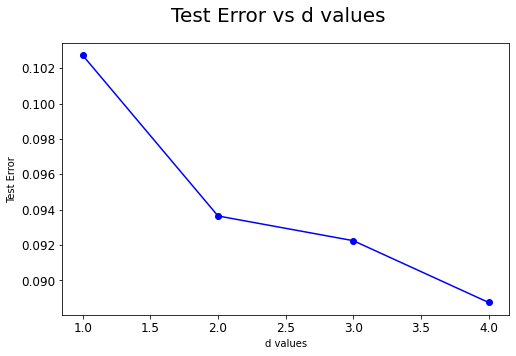

In [14]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize = (8,5)) 
plt.plot(d_vals, error_test ,marker='o', color='b')
plt.suptitle('Test Error vs d values', fontsize=20)
plt.xlabel('d values', fontsize=10)
plt.ylabel('Test Error', fontsize=10);

## PART 4 

## Number of support vectors

**Plot the number of support vectors obtained as a function of $d$.**

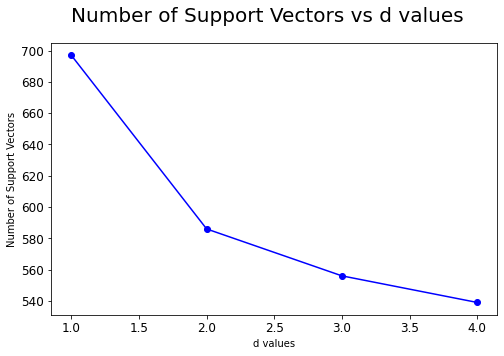

In [15]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize = (8,5)) 
plt.plot(d_vals, support_vectors, marker='o', color='b')
plt.suptitle('Number of Support Vectors vs d values', fontsize=20)
plt.xlabel('d values', fontsize=10)
plt.ylabel('Number of Support Vectors', fontsize=10);

## PART 5 

## Number of Margin Violations

**Plot the number of support vectors that violate the margin hyperplanes as a function of $d.**

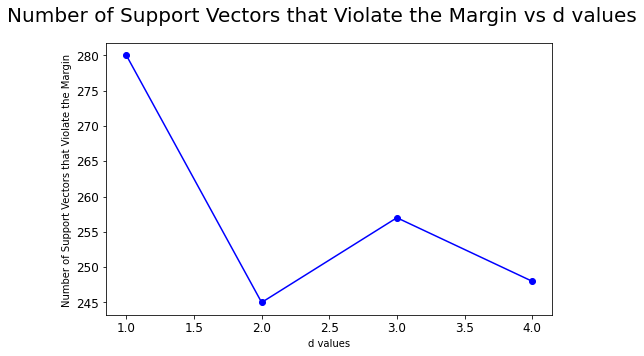

In [16]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize = (8,5)) 
plt.plot(d_vals, margin_violations, marker='o', color='b')
plt.suptitle('Number of Support Vectors that Violate the Margin vs d values', fontsize=20)
plt.xlabel('d values', fontsize=10)
plt.ylabel('Number of Support Vectors that Violate the Margin ', fontsize=10);

## PART 6  

## Margin Size vs Support Vectors

**Explain how the parameter $d$ infuences the model fit (plot the margin size as a function of $d).**

Make sure to plot **AND** explain.

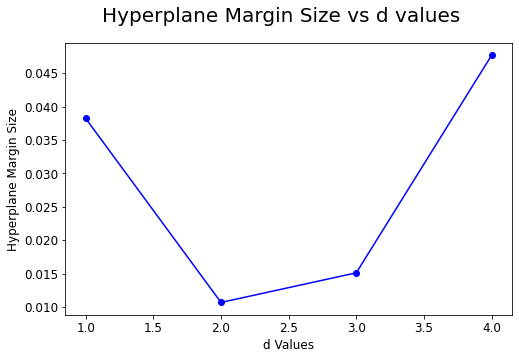

In [17]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize = (8,5)) 
plt.plot(d_vals, margin_size, marker='o', color='b')
plt.suptitle('Hyperplane Margin Size vs d values', fontsize=20)
plt.xlabel('d Values', fontsize=12)
plt.ylabel('Hyperplane Margin Size', fontsize=12);

In [ ]:
## Comments

The plot of parameter $d$ vs hyperplane margin size is a **inverse bell curve**, which means as $d$ increases, the size of hyperplane margin goes down and reaches a minimum value, then it goes up as $d$ increases.